# Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
from datetime import datetime

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Activation, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.initializers import RandomUniform

In [3]:
import sherpa

# Load Data

In [4]:
#####################################################################################################
################################ Select numbers of year of data #####################################
#####################################################################################################
year = 10 # years of data to compare 10 or 5

In [5]:
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] 

PSIdf = pd.read_csv(r'stock_indices/PSI_{}y.csv'.format(year), usecols = cols).drop(columns = ['Adj Close'])
SOXXdf = pd.read_csv(r'stock_indices/SOXX_{}y.csv'.format(year), usecols = cols).drop(columns = ['Adj Close'])
USDdf = pd.read_csv(r'stock_indices/USD_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])
SMHdf = pd.read_csv(r'stock_indices/SMH_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])
SOXLdf = pd.read_csv(r'stock_indices/SOXL_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])
TSMdf = pd.read_csv(r'stock_indices/TSM_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])

In [6]:
restCol = lambda name: { h:   name + ' ' + h   for h in ['Volume', 'Close', 'Open', 'High', 'Low']}

PSIdf.rename(columns = restCol('PSI'), inplace = True)
SOXXdf.rename(columns = restCol('SOXX'), inplace = True)
USDdf.rename(columns = restCol('USD'), inplace = True)
SMHdf.rename(columns = restCol('SMH'), inplace = True)
SOXLdf.rename(columns = restCol('SOXL'), inplace = True)
TSMdf.rename(columns = restCol('TSM'), inplace = True)

# if mergeAll:
#     df = pd.merge(PSIdf, SOXXdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
#     df = pd.merge(df, USDdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
#     df = pd.merge(df, SMHdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
#     df = pd.merge(df, SOXLdf, how = 'inner', on = 'Date', sort=True).set_index(['Date'])  
#     df = pd.merge(df, TSMdf, how = 'inner', on = 'Date', sort=True).set_index(['Date'])  

In [7]:
######################################################################################################
################################### Select the indice for input ######################################
######################################################################################################
indiceToCmpr = SMHdf #PSIdf # SOXXdf, USDdf, SMHdf, SOXLdf
includeTargInInput = True

In [8]:
df = pd.merge(indiceToCmpr, TSMdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
df['TSM Avg'] = (df['TSM High'] + df['TSM Low'])/2

In [9]:
target_col = ['TSM Avg']
input_col = [col for col in df.columns if 'TSM' not in col] if not includeTargInInput else df.columns
print("The input col is: ", input_col)

('The input col is: ', Index([u'SMH Open', u'SMH High', u'SMH Low', u'SMH Close', u'SMH Volume',
       u'TSM Open', u'TSM High', u'TSM Low', u'TSM Close', u'TSM Volume',
       u'TSM Avg'],
      dtype='object'))


In [10]:
#####################################################################################################
################################### shift days ######################################################
#####################################################################################################
shift_steps = 5 #shift day

In [11]:
#With shift
if shift_steps:
    df_targets = df[target_col].shift(-shift_steps)
    y_data = df_targets.values[0:-shift_steps]
    x_data = df[input_col].values[0:-shift_steps]
else:
    #No shift
    df_targets = df[target_col]
    y_data = df_targets.values
    x_data = df[input_col].values

### NumPy Arrays

In [12]:
print(type(x_data))
print("Shape:", x_data.shape)

<type 'numpy.ndarray'>
('Shape:', (2261, 11))


In [13]:
print(type(y_data))
print("Shape:", y_data.shape)

<type 'numpy.ndarray'>
('Shape:', (2261, 1))


In [14]:
num_data = len(x_data)
num_data

2261

In [15]:
train_split = 0.8

In [16]:
num_train = int(train_split * num_data)
num_train

1808

In [17]:
num_test = num_data - num_train
num_test

453

In [18]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

2261

In [19]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

2261

In [20]:
num_x_signals = x_data.shape[1]
num_x_signals

11

In [21]:
num_y_signals = y_data.shape[1] if len(target_col) > 1 else 1

### Scaled Data

In [22]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

('Min:', 9.3)
('Max:', 44473500.0)


In [23]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train) # calculate std and mean, store it into xscaler, apply that to transform
x_test_scaled = x_scaler.transform(x_test)

In [24]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

('Min:', 0.0)
('Max:', 1.0)


In [25]:
if num_y_signals == 1:
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)     #reshape to fit numpy array of shape [n_samples, n_features]

In [26]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Data Generator

In [27]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(1808, 11)
(1808, 1)


In [28]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [29]:
batch_size = 256

In [30]:
sequence_length = 100

In [31]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [32]:
x_batch, y_batch = next(generator)

In [33]:
print(x_batch.shape)
print(y_batch.shape)

(256, 100, 11)
(256, 100, 1)


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


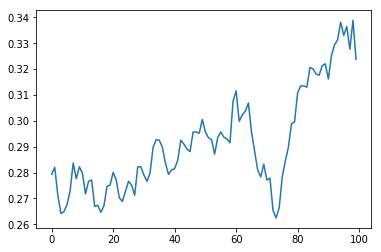

In [34]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

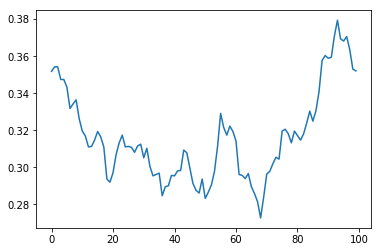

In [35]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

In [36]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Create the Recurrent Neural Network

In [37]:


# Maybe use lower init-ranges.
# init = RandomUniform(minval=-0.05, maxval=0.05)
# model.add(Dense(num_y_signals,activation='relu',kernel_initializer=init, kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dense(num_y_signals, Dropout(0.5))) # dropout layer
# model.add(Dense(num_y_signals,activation='relu',kernel_initializer=init))

### Loss Function

In [38]:
warmup_steps = 50

In [39]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile Model

### Callback Functions

In [40]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [41]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [42]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

In [43]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [44]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Estimate training time

In [45]:
import time
t0 = time.time()

# Train the Neural Network

In [46]:
parameters = [sherpa.Discrete('num_units', [50, 550])]
alg = sherpa.algorithms.BayesianOptimization(max_num_trials=10)
study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running on http://192.168.0.28:8880
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
----------------------------------------
 ----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60440)
Exception happened during processing of request from ('127.0.0.1', 60438)
Exception happened during processing of request from ('127.0.0.1', 60439)


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, self)
    self.Request

----------------------------------------


error: [Errno 32] Broken pipe


 ----------------------------------------
----------------------------------------
 ----------------------------------------
----------------------------------------
 ----------------------------------------
 ----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60517)


Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 60516)
Exception happened during processing of request from ('127.0.0.1', 60518)
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60519)


Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 60515)
 ----------------------------------------


Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


Exception happened during processing of request from ('127.0.0.1', 60520)


Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


Exception happened during processing of request from ('127.0.0.1', 60521)


    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
Traceback (most recent call last):
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
Traceback (most recent call last):
Traceback (most recent call last):
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596,

----------------------------------------


    self.wfile.close()
    self.flush()
    self.flush()
    self.wfile.close()


Exception happened during processing of request from ('127.0.0.1', 60580)


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
Traceback (most recent call last):
    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
    self.flush()
error: [Errno 32] Broken pipe
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_req

----------------------------------------
 ----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
    self.finish()


 ----------------------------------------


    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
error: [Errno 32] Broken pipe


----------------------------------------


error: [Errno 32] Broken pipe
error: [Errno 32] Broken pipe
    self.wfile.close()
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
error: [Errno 32] Broken pipe


 ----------------------------------------


    self.flush()


----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush


 ----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe


----------------------------------------
----------------------------------------
 ----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60710)
Exception happened during processing of request from ('127.0.0.1', 60709)
Exception happened during processing of request from ('127.0.0.1', 60711)


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/k

----------------------------------------
 ----------------------------------------
----------------------------------------
----------------------------------------
 ----------------------------------------
 ----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61397) ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61396)
Exception happened during processing of request from ('127.0.0.1', 61395)
Exception happened during processing of request from ('127.0.0.1', 61394)
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61398)


Traceback (most recent call last):


Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 61399)


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)


 ----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


Exception happened during processing of request from ('127.0.0.1', 61410)
Exception happened during processing of request from ('127.0.0.1', 61400)


    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
Traceback (most recent call last):
    self.finish_request(request, client_address)
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, se

----------------------------------------


    self.wfile.close()
    self.flush()
    self.finish()
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
error: [Errno 32] Broken pipe
    self.flush()
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
    self.wfile.close()
    self.flush()


----------------------------------------


error: [Errno 32] Broken pipe
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush


 ----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush


----------------------------------------


    self.flush()
error: [Errno 32] Broken pipe
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush


----------------------------------------


error: [Errno 32] Broken pipe
error: [Errno 32] Broken pipe


----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])


----------------------------------------


error: [Errno 32] Broken pipe


----------------------------------------
----------------------------------------
 ----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61913)
Exception happened during processing of request from ('127.0.0.1', 61914)
Exception happened during processing of request from ('127.0.0.1', 61915)


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, self)
    self.Request

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61940)


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
Traceback (most recent call last):
    self.wfile.close()
    self.finish()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self.wfile.close()
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
    self.flush()
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
  File "/Users/kuoweichiao/minico

----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
error: [Errno 32] Broken pipe


----------------------------------------
 ----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe


----------------------------------------
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61985)


Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
    self.finish()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
    self.wfile.close()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe


----------------------------------------
----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 62282)
Exception happened during processing of request from ('127.0.0.1', 62283)


Traceback (most recent call last):


 ----------------------------------------


Traceback (most recent call last):


----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 62281)
Exception happened during processing of request from ('127.0.0.1', 62285)
Exception happened during processing of request from ('127.0.0.1', 62284)


    self.finish_request(request, client_address)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.finish_request(request, client_address)
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
    self.finish_reques

----------------------------------------


    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
    self.flush()
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
error: [Errno 32] Broken pipe
error: [Errno 32] Broken pipe
    self._sock.sendall(view[write_offset:write_offset+buffer_size])


----------------------------------------
 ----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe


----------------------------------------


error: [Errno 32] Broken pipe


 ----------------------------------------
----------------------------------------
 ----------------------------------------
 ----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 62747)
Exception happened during processing of request from ('127.0.0.1', 62748)
Exception happened during processing of request from ('127.0.0.1', 62750)
Exception happened during processing of request from ('127.0.0.1', 62749)
 ----------------------------------------


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 62751)


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 62752)


    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  

----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])


 ----------------------------------------
 ----------------------------------------


    self._sock.sendall(view[write_offset:write_offset+buffer_size])


 ----------------------------------------


error: [Errno 32] Broken pipe
error: [Errno 32] Broken pipe


----------------------------------------
----------------------------------------
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 63912)


Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
    self.finish()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
    self.wfile.close()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe


----------------------------------------
 ----------------------------------------

---------------------------------------- ----------------------------------------
 ----------------------------------------
 ----------------------------------------
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 63933)
Exception happened during processing of request from ('127.0.0.1', 63934)


Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 63935)
Exception happened during processing of request from ('127.0.0.1', 63930)
Exception happened during processing of request from ('127.0.0.1', 63931)
Exception happened during processing of request from ('127.0.0.1', 63932)


Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_

----------------------------------------
 ----------------------------------------


error: [Errno 32] Broken pipe


 ----------------------------------------


error: [Errno 32] Broken pipe
error: [Errno 32] Broken pipe



----------------------------------------
---------------------------------------- ----------------------------------------
 ----------------------------------------
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 65212)


Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 65211)


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
Traceback (most recent call last):
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
    self.finish()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
    self.finish()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
    self.wfile.close()
  File

----------------------------------------


error: [Errno 32] Broken pipe


----------------------------------------
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 65282)


Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
    self.finish()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
    self.wfile.close()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
    self.flush()


 ----------------------------------------
 ----------------------------------------
----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush


Exception happened during processing of request from ('127.0.0.1', 65298)
 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 65299)
 ----------------------------------------


Traceback (most recent call last):


Exception happened during processing of request from ('127.0.0.1', 65297)


    self._sock.sendall(view[write_offset:write_offset+buffer_size])


Exception happened during processing of request from ('127.0.0.1', 65296)


error: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


Exception happened during processing of request from ('127.0.0.1', 65301)
 ----------------------------------------
 ----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread


 ----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 65302)


Traceback (most recent call last):
Traceback (most recent call last):
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
Traceback (most recent call last):
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 596, in process_request_thread
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.finish_request(request, client_address)
    self.finish_request(request, client_address)


Exception happened during processing of request from ('127.0.0.1', 65300)


    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.finish_request(request, client_address)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 654, in __init__
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 331, in finish_request
Traceback (most recent call last):
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, self)
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", li

----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/SocketServer.py", line 713, in finish
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
error: [Errno 32] Broken pipe
    self.wfile.close()
error: [Errno 32] Broken pipe
    self.wfile.close()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close


----------------------------------------


    self.flush()
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush


----------------------------------------


    self.flush()
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 283, in close
error: [Errno 32] Broken pipe
    self._sock.sendall(view[write_offset:write_offset+buffer_size])


----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
error: [Errno 32] Broken pipe
    self.flush()


----------------------------------------


  File "/Users/kuoweichiao/miniconda3/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe


----------------------------------------


error: [Errno 32] Broken pipe


 ----------------------------------------


In [47]:
# %%time
for trial in study:
    model = Sequential()
    model.add(GRU(units=trial.parameters['num_units'],
                  return_sequences=True,
                  input_shape=(None, num_x_signals,)))
    model.add(Dense(num_y_signals, activation='relu'))  
    optimizer = RMSprop(lr=1e-3)
    model.compile(loss=loss_mse_warmup, optimizer=optimizer)
    model.summary()

    history = model.fit_generator(generator=generator,
                        epochs=10,
                        steps_per_epoch=100,
                        validation_data=validation_data,
                        callbacks=callbacks + [study.keras_callback(trial, objective_name='val_loss')])

    study.finalize(trial)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 50)          9300      
_________________________________________________________________
dense (Dense)                (None, None, 1)           51        
Total params: 9,351
Trainable params: 9,351
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00001: val_loss improved from inf to 0.01907, saving model to 23_checkpoint.keras
100/100 [==============================] - 34s 337ms/step - loss: 0.0022 - val_loss: 0.0191
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00002: val_loss improved from 0.01907 to 0.00864, saving model to 23_checkpoint.keras
100/100 [==============================] - 31s 312ms/step - loss: 0.0012 - val_loss: 0.0086
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00003: val_loss improved from 0.00864 to 0.00423, saving model to 23_checkpoint.keras
100/100 [==============================] - 32s 320ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 9.2033e-04
Epoch 00004: val_loss did not improve from 0.00423

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
100/100 [====

/Users/kuoweichiao/miniconda3/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 300)         280800    
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           301       
Total params: 281,101
Trainable params: 281,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0080
Epoch 00001: val_loss did not improve from 0.00279
100/100 [==============================] - 128s 1s/step - loss: 0.0080 - val_loss: 0.0110
Epoch 2/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0019
Epoch 00002: val_loss did not improve from 0.00279
100/100 [==============================] - 122s 1s/step - loss: 0.0019 - val_loss: 0.0043
Epoch 3/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0013
Epoch 00003: val_lo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, None, 259)         210567    
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           260       
Total params: 210,827
Trainable params: 210,827
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0079
Epoch 00001: val_loss did not improve from 0.00261
100/100 [==============================] - 112s 1s/step - loss: 0.0078 - val_loss: 0.0202
Epoch 2/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0019
Epoch 00002: val_loss did not improve from 0.00261
100/100 [==============================] - 120s 1s/step - loss: 0.0019 - val_loss: 0.0052
Epoch 3/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0013
Epoch 00003: val_lo

In [48]:
print("Training time: ", round(time.time()-t0, 3), "s")

('Training time: ', 10407.486, 's')


### Load Checkpoint

In [49]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Shapes (11, 1608) and (11, 609) are incompatible


# Performance on Test-Set

In [50]:
loss = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 421ms/step


In [51]:
print("loss (test-set):{0}".format(loss))

loss (test-set):0.00285938684829


In [52]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

# Generate Predictions

In [53]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print("y_pred length: ", len(y_pred))
    print("y_true length: ",len(y_true))
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    print("y_pred_rescaled length: ", len(y_pred_rescaled))
    print("Explained variance score (EVS): ", explained_variance_score(y_true, y_pred_rescaled))
    
    # For each output-signal.
    for signal in range(len(target_col)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        #plt.ylabel(target_names[signal])
        plt.ylabel('TSM Average')
        plt.legend()
        plt.show()

('y_pred length: ', 1)
('y_true length: ', 1200)
('y_pred_rescaled length: ', 1200)
('Explained variance score (EVS): ', 0.9823845369466171)


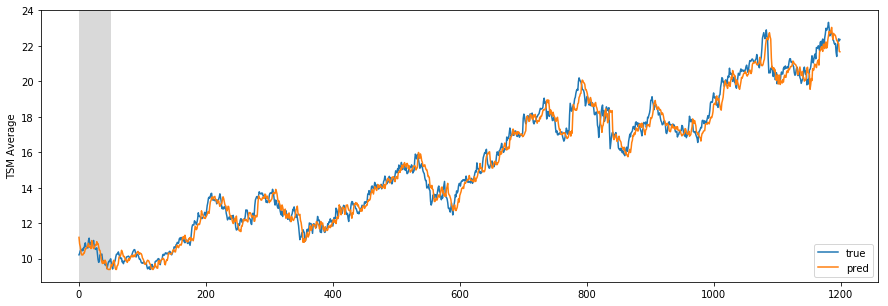

In [54]:
plot_comparison(start_idx=0, length=1200, train=True)

### Example from Test-Set

('y_pred length: ', 1)
('y_true length: ', 260)
('y_pred_rescaled length: ', 260)
('Explained variance score (EVS): ', 0.8000037208750523)


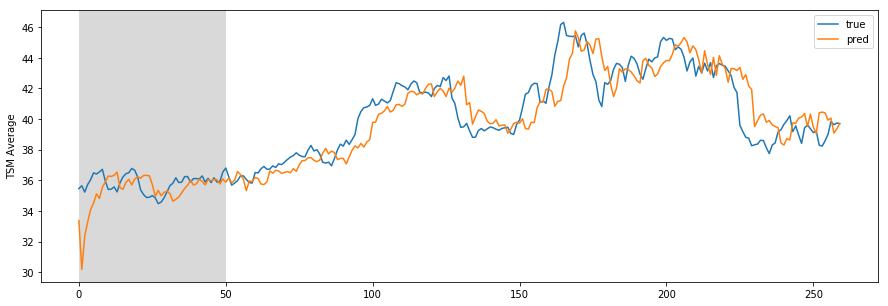

In [55]:
plot_comparison(start_idx=0, length=260, train=False)

### Summarize history of loss

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


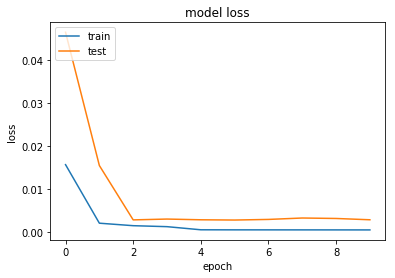

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()